# Spanish Translation A/B test

In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from scipy.stats import ttest_ind, describe

## Background

Conversion rate comparsion between Spain-based users and non-Spain-based users (all are Spanish-speaking countries).

Sites are changed to localized translation in non-Spain countries in hope to increase conversion rate.

## Objective

1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.


In [2]:
# results from the A/B test (user_id, device, channel, conversios, test, and etc)
test_data = pd.read_csv('test_table.csv')

# user information (user_id, sex, age, and country)
user_data = pd.read_csv('user_table.csv')

In [3]:
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
user_data.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


## Merging two datasets together by user_id

In [5]:
print(len(set(user_data.user_id)) == len(set(test_data.user_id)))
print('number of unique id in user_data:', len(set(user_data.user_id)))
print('number of unique id in test_data:', len(set(test_data.user_id)))     

False
number of unique id in user_data: 452867
number of unique id in test_data: 453321


Since there are more unique ids in test data than user data, some rows in our new table will have missing user info values

In [6]:
combined_data = test_data.merge(user_data, how ='left', on = 'user_id')

In [7]:
combined_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


***

## Question 1: Is the old version of the site doing better?

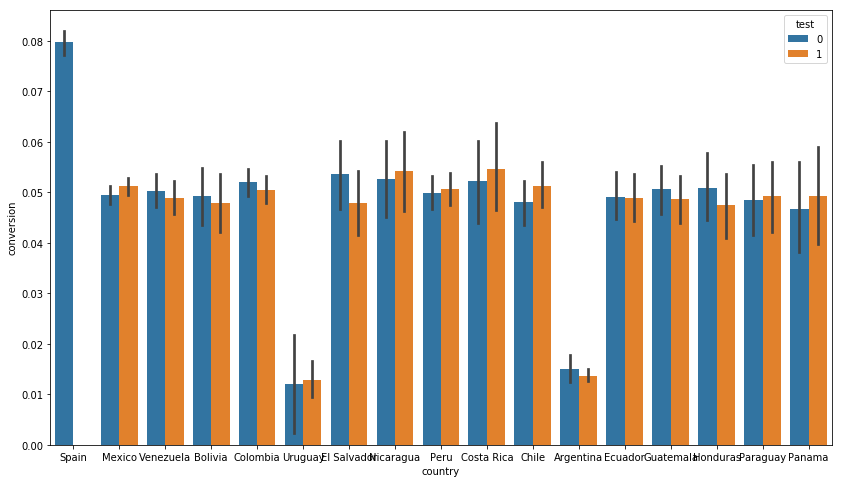

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x='country', y='conversion', hue='test', data=combined_data, ax=ax)
plt.show()

In [9]:
# exclude spain's data

other_countries = combined_data[combined_data['country'] != 'Spain']

# filter out the test group and the control group

control_group = other_countries[other_countries['test'] == 0]
test_group = other_countries[other_countries['test'] == 1]

In [10]:
print(control_group.conversion.describe(), '\n'*5,\
      test_group.conversion.describe())

count    185556.000000
mean          0.048330
std           0.214464
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: conversion, dtype: float64 




 count    215983.000000
mean          0.043425
std           0.203812
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: conversion, dtype: float64


In [11]:
ttest_ind(control_group.conversion, test_group.conversion, equal_var=False)

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)

Since the p-value is less than 0.05 and the statistic is positive, we are able to reject the null hypothesis (test group mean = control group mean) and conclude that the control group (old version) is doing better than the new version.

***

## Quesion 2 : Why is this happening?

## Let's look at countries

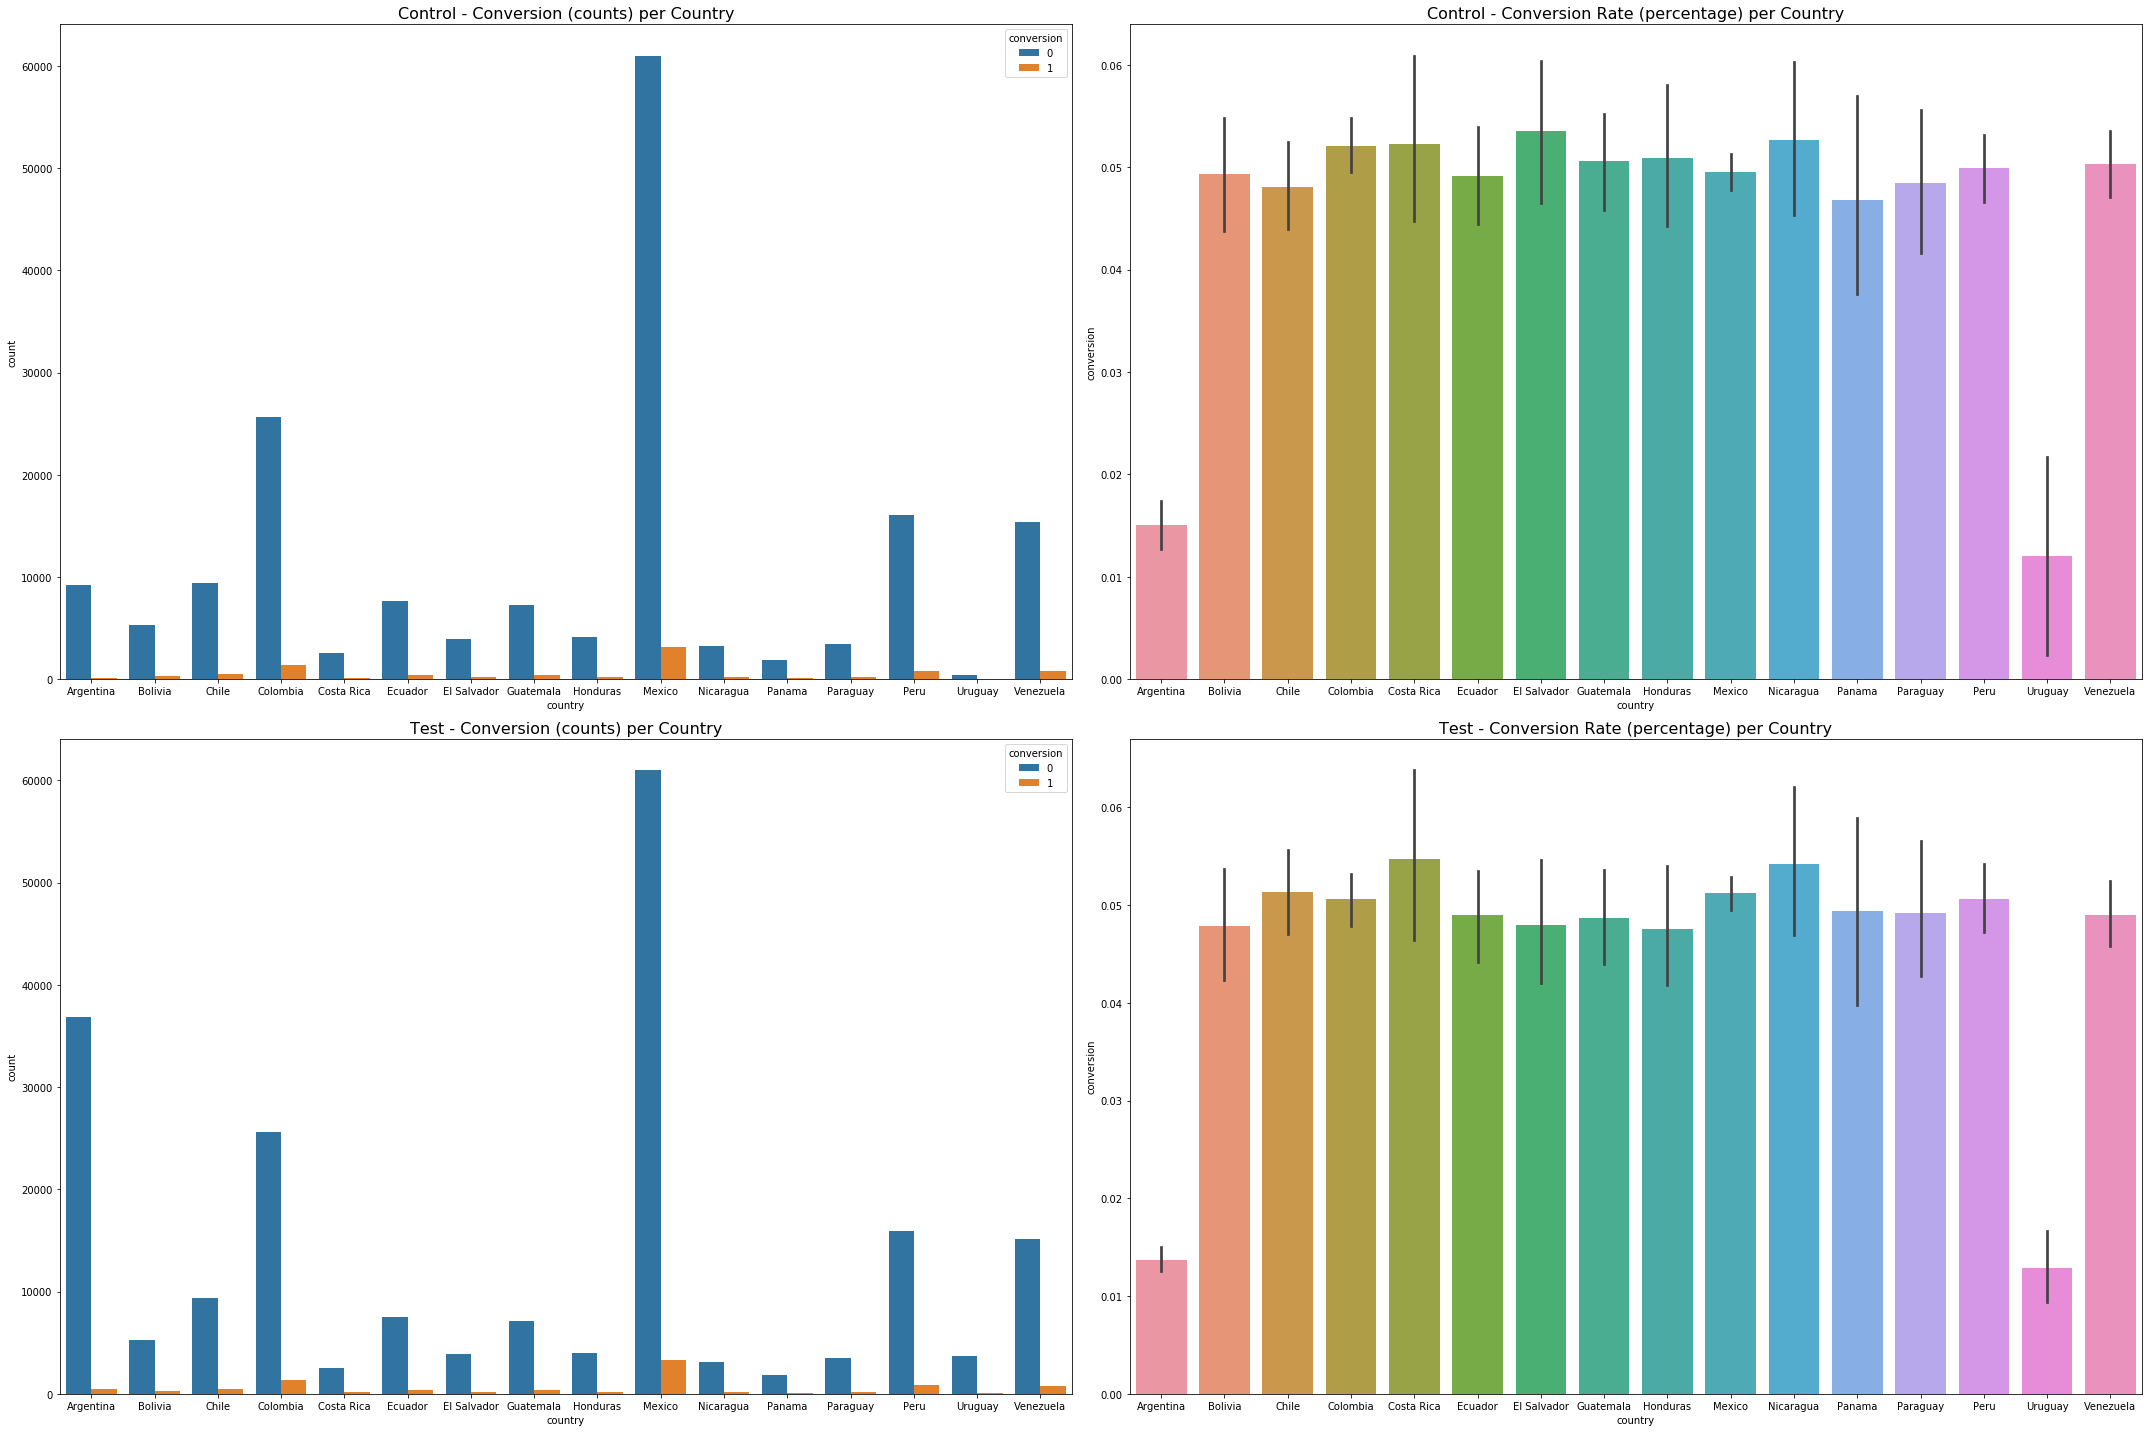

In [12]:
country_list = test_group.groupby('country').conversion.mean().index

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

sns.countplot(x='country', hue='conversion', data = control_group, order = country_list, ax = ax[0][0])
ax[0][0].set_title('Control - Conversion (counts) per Country', fontsize=16)
sns.barplot(x='country', y='conversion', data = control_group, order = country_list, ax= ax[0][1])
ax[0][1].set_title('Control - Conversion Rate (percentage) per Country', fontsize=16)

sns.countplot(x='country', hue='conversion', data = test_group, order = country_list, ax = ax[1][0])
ax[1][0].set_title('Test - Conversion (counts) per Country', fontsize=16)
sns.barplot(x='country', y='conversion', data = test_group, order = country_list, ax= ax[1][1])
ax[1][1].set_title('Test - Conversion Rate (percentage) per Country', fontsize=16)


plt.tight_layout()
plt.show()

Doesn't seem to show significant drop in one/some countries.

## Look at the sources / traffic funnel / browser of the data

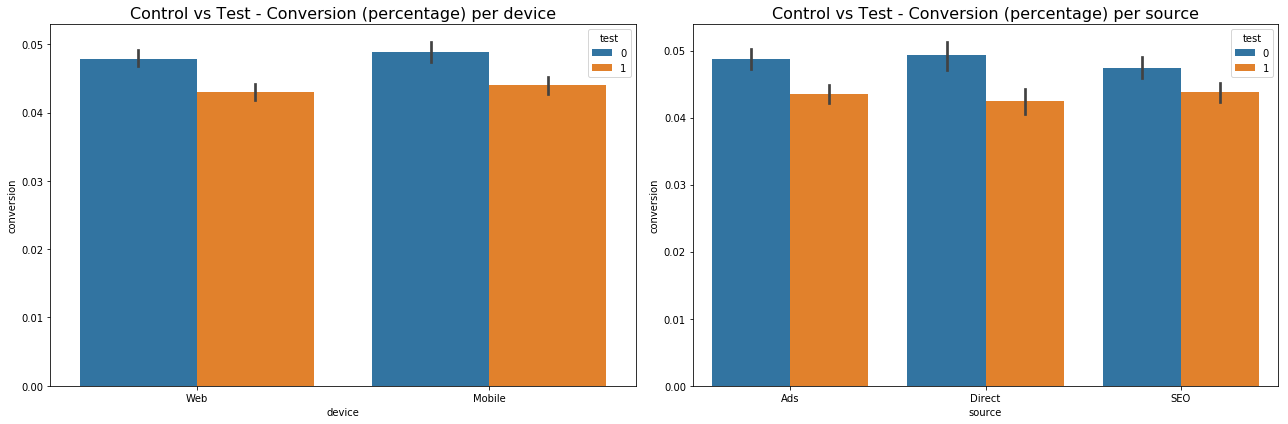

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.barplot(x='device', y='conversion', hue = 'test', data = other_countries, ax = ax[0])
ax[0].set_title('Control vs Test - Conversion (percentage) per device', fontsize=16)
sns.barplot(x='source', y='conversion', hue = 'test', data = other_countries, ax = ax[1])
ax[1].set_title('Control vs Test - Conversion (percentage) per source', fontsize=16)


plt.tight_layout()
plt.show()

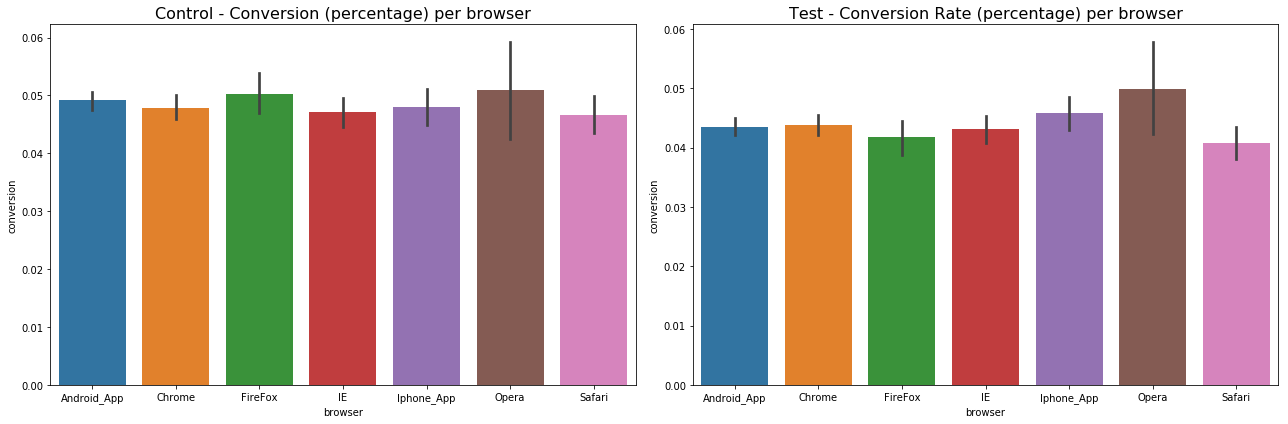

In [14]:
browser_list = test_group.groupby('browser').conversion.mean().index

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='browser', y='conversion', data = control_group, order = browser_list, ax = ax[0])
ax[0].set_title('Control - Conversion (percentage) per browser', fontsize=16)
sns.barplot(x='browser', y='conversion', data = test_group, order = browser_list, ax= ax[1])
ax[1].set_title('Test - Conversion Rate (percentage) per browser', fontsize=16)
plt.tight_layout()
plt.show()

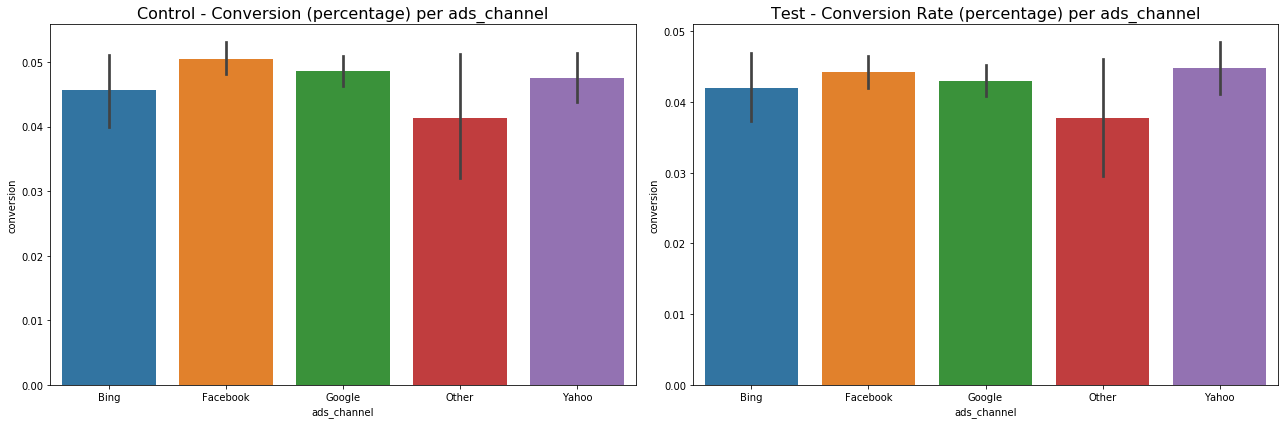

In [15]:
ads_list = test_group.groupby('ads_channel').conversion.mean().index

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='ads_channel', y='conversion', data = control_group, order = ads_list, ax = ax[0])
ax[0].set_title('Control - Conversion (percentage) per ads_channel', fontsize=16)
sns.barplot(x='ads_channel', y='conversion', data = test_group, order = ads_list, ax= ax[1])
ax[1].set_title('Test - Conversion Rate (percentage) per ads_channel', fontsize=16)
plt.tight_layout()
plt.show()

The conversion percentage of the test group drops overall in all the sources; hence, we don't see any evidence showing that the sources are affecting the drop.

The browsers and the ads channels show the same result. The conversion rate drops fairly proportionally, throughout all the different browsers and ads channels.

## How about age?

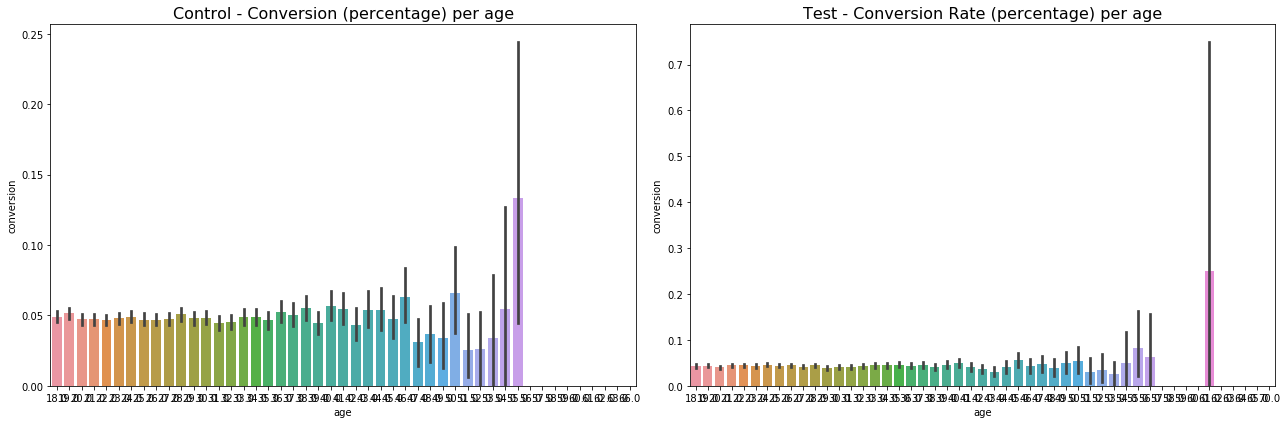

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='age', y='conversion', data = control_group, ax = ax[0])
ax[0].set_title('Control - Conversion (percentage) per age', fontsize=16)
sns.barplot(x='age', y='conversion', data = test_group, ax= ax[1])
ax[1].set_title('Test - Conversion Rate (percentage) per age', fontsize=16)
plt.tight_layout()
plt.show()

Same, the percentages drop proportionally. Not seeing any one factor causing a significant drop.

## How about the dates?

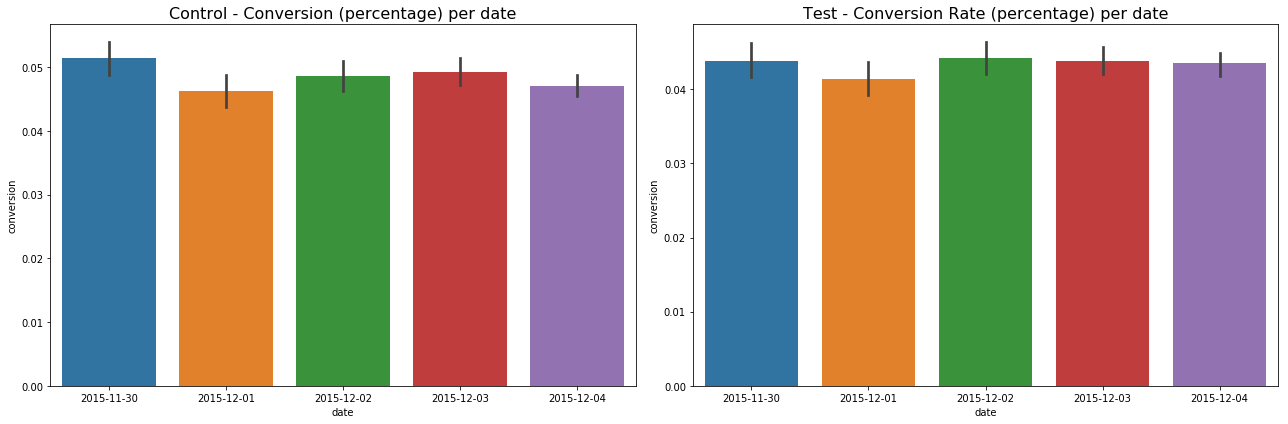

In [17]:
date_list = test_group.groupby('date').conversion.mean().index

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='date', y='conversion', data = control_group, order = date_list, ax = ax[0])

ax[0].set_title('Control - Conversion (percentage) per date', fontsize=16)
sns.barplot(x='date', y='conversion', data = test_group, order = date_list, ax= ax[1])
ax[1].set_title('Test - Conversion Rate (percentage) per date', fontsize=16)
plt.tight_layout()
plt.show()

Since the data only shows five days of the ab tests, the result might be affected by our bias of making a conclusion with insufficient amount of data. Because in the common practice of A/B testing, the test should run at least 14 days to capture the weekly pattern. Drawing a conclusion with just five days of data is too reckless; thus, might lead to mistakenly concluded that the test group is not doing well when it is actually performing well. 

## How about their browser language?

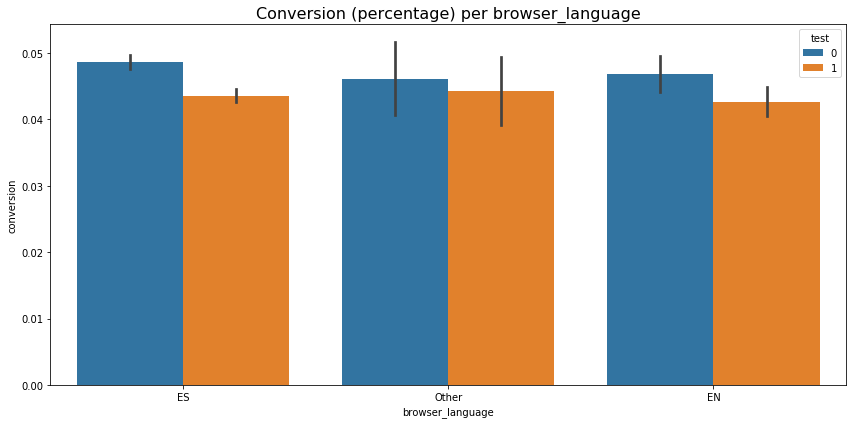

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

sns.barplot(x='browser_language', y='conversion', hue = 'test', data = other_countries)
ax.set_title('Conversion (percentage) per browser_language', fontsize=16)
plt.tight_layout()
plt.show()

Since this test is about translation, we can predict the users' default language by looking at their browser language. 

We can see that there's a low variance in distribution and a significant drop in the test group of the ES browser language group. My guess is that this group of people already have a very proficient or advanced level in Spanish. The localized translation is unnecessary and might even give them a negative impression.


The EN group also shows a significant decrease. This might be due to the reason that the localized translation might actually give them a hard time to understand the language on the site.

***

## Question 3: Design an algorithm to prevent this mistake

1. The data team should check the quality of the data before they make inferences (i.e do they have enough data to make conclusions)
2. Need a deeper understanding of how the change will affect different groups of users.